# Introduction to NEMS

Modeling with NEMS four basic steps:
1. Loading properly formatted data and performing any necessary preprocessing.
1. Building a model for the data.
1. Fitting the model to the data.
1. Assessing model performance.

In this introduction, we'll cover the basic coding objects used to accomplish
those steps and then walk through a simple example.

## Data format
All data should be formatted as `NumPy` arrays. NEMS models assume timeseries
data is provided with shape (T, ..., N), where T is the number of time points
and N is the number of output channels (or neurons). Data with shape
(S, T, ..., N) is also supported through optional arguments, where S represents
some number of trials or samples.

For example, a 10-second long recording of activity from 100 neurons sampled
at 100 Hz should be provided as shape (1000, 100), and a corresponding 18-channel
spectrogram with the same sampling rate should have shape (1000, 18).

## Important objects
1. `Layer`: encapsulates a single mathematical transformation and an associated
          set of trainable parameters.
1. `Model`: a collection of Layers that determines the transformation between input
          data and the predicted output.

## Layer
Most Layers have one or more trainable `Parameter` values tracked by a single
`Phi` container. These objects determine the trainable numbers that will be
substituted in the mathematical operation specified by `Layer.evaluate`.
The `Parameter` and `Phi` classes can be thought of as numpy arrays and python
dictionaries, respectfully, with some NEMS-specific bookkeeping tacked on.
Default `Parameter` values are determined by the `Layer.initial_parameters`
method.

Let's design a couple new Layer subclasses to demonstrate:

In [63]:
import numpy as np
from nems.layers.base import Layer, Phi, Parameter

class Sum(Layer):
    def evaluate(self, *inputs):
        # All inputs are treated the same, no fittable parameters.
        return np.sum(inputs, axis=0)

class WeightedSum(Layer):

    def initial_parameters(self):
        a = Parameter('a')
        b = Parameter('b')
        return Phi(a, b)

    def evaluate(self, input1, input2):
        # Only two inputs are supported, and they are weighted differently.
        a, b = self.get_parameter_values('a', 'b')
        return a*input1 + b*input2

Now, let's create some instances of our new `Layers` and take a look at a summary
of their properties.

In [64]:
sum = Sum()
sum

Sum(shape=None)

In [65]:
weighted = WeightedSum()
weighted

WeightedSum(shape=None)
Parameter(name=a, shape=())
----------------
Parameter(name=b, shape=())

Notice that the two `Parameters` we created for the `WeightedSum` subclass
show up here. If we want to see more detail, like their numeric values,
we can `print` a full report for the `Layer` instead:

In [66]:
print(weighted)

WeightedSum(shape=None)
.parameters:

Parameter(name=a, shape=())
----------------
.prior:     Normal(μ=0.0, σ=1.0)
.bounds:    (-inf, inf)
.is_frozen: False
.values:
0.0
----------------
Index: 0
----------------

Parameter(name=b, shape=())
----------------
.prior:     Normal(μ=0.0, σ=1.0)
.bounds:    (-inf, inf)
.is_frozen: False
.values:
0.0
----------------
Index: 0
----------------



We can see that both parameters currently have a value of 0. This is because
the default behavior for parameter intialization is to set the values to the
mean of each `Parameter`'s prior `Distribution`. Since we didn't specify the
`Distribution` ourselves, it defaulted to a normal distribution with mean zero
and standard deviation 1. To choose a different prior, we could have specified
it in the `initial_parameters` method using the `prior` keyword argument of the
`Parameter` class, or we can set it when creating a new `WeightedSum` instance:

In [67]:
from nems.distributions import HalfNormal

weighted = WeightedSum(priors={'a': HalfNormal(sd=1)})
# equivalent to Parameter(..., prior=HalfNormal(sd=1))
print(weighted)

WeightedSum(shape=None)
.parameters:

Parameter(name=a, shape=())
----------------
.prior:     HalfNormal(σ=1)
.bounds:    (-inf, inf)
.is_frozen: False
.values:
0.7978845608028654
----------------
Index: 0
----------------

Parameter(name=b, shape=())
----------------
.prior:     Normal(μ=0.0, σ=1.0)
.bounds:    (-inf, inf)
.is_frozen: False
.values:
0.0
----------------
Index: 0
----------------



Let's evaluate some toy data to see how to use the `Layers`:

In [68]:
x = np.ones(shape=(10,1))
y = np.ones(shape=(10,1))*2

sum.evaluate(x,y)

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

Pretty straightforward: the two inputs are added together along the first axis.
With `WeightedSum`, however, the second input should be zero'd out, so that we
get `a * x` for our output:

In [69]:
weighted.evaluate(x,y)

array([[0.79788456],
       [0.79788456],
       [0.79788456],
       [0.79788456],
       [0.79788456],
       [0.79788456],
       [0.79788456],
       [0.79788456],
       [0.79788456],
       [0.79788456]])

## Model

A `Model` coordinates the evaluation of one or `Layer` instances to describe
a composite transformation. For example, we can combine the `WeightedSum`
subclass we created with a new `Layer` to get a toy `Model` that computes a
weighted sum of two inputs and squares the result.

In [70]:
from nems import Model

class Square(Layer):
    def evaluate(self, input):
        return input ** 2

data = {'x': np.random.rand(20,1),
        'y': np.random.rand(20,1)}

model = Model()
model.add_layers(
    WeightedSum(input=['x', 'y']),
    Square()
)
model

Model()
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
WeightedSum(shape=None)
Parameter(name=a, shape=())
----------------
Parameter(name=b, shape=())

Square(shape=None)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Similar to the `Layer` class, we get a brief summary of the `Model` here. The
order within the `Model` determines the flow of data: the output of each `Layer`
is provided as input to the subsequent `Layer` moving from top to bottom, unless
a `Layer` specifies its `input` separately.

To transform the data, we use `Model.evaluate`. By default, this produces a
dictionary containing all of the input data, any named intermediate outputs,
and the final model output (with a default name of 'output'). If we only want
the output, we can use the `return_full_data=False` keyword argument, or
we can use `Model.predict`.

In [71]:
dict_out = model.evaluate(data)
print(dict_out.keys())

dict_keys(['x', 'y', 'output'])


In [72]:
out = model.predict(data)
out.T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

Currently our output is all zeroes because the default `Parameter` values are
all zeroes. Let's try it with randomly sampled values instead. First, we create
a new randomized model and print its `Parameter` values, then generate a new
output.

In [73]:
model = model.sample_from_priors()
print(model.get_parameter_values())
out = model.predict(data)
out.T

{'WeightedSum': {'a': array(1.55925701), 'b': array(0.34733557)}, 'Square': {}}


array([[0.72907787, 0.300961  , 2.73497655, 1.12274434, 1.50585002,
        2.36493779, 0.6009686 , 0.28224823, 1.2895773 , 1.91118131,
        0.78361893, 0.93467805, 1.50925873, 0.39563321, 0.42749202,
        0.72356307, 1.42614169, 3.04890762, 2.55257048, 0.16056492]])

Finally, let's use `Model.fit` to try to match some target data. A successful
fit should be able to find the correct parameter values, `|a|=2` and `|b|=1.5`.

In [76]:
target = (2*data['x'] - 1.5*data['y'])**2
fitted_model = model.fit(data, target)
print(f"\nFitted parameter values:\n{fitted_model.get_parameter_values()}")

Epoch 0
        Iteration 0, error is: 1.05899703...
        Iteration 5, error is: 0.15242677...
        Iteration 10, error is: 0.00375500...
        Iteration 15, error is: 0.00012019...
        Iteration 20, error is: 0.00000386...
        Iteration 25, error is: 0.00000012...
Fit successful: False
Status: 2
Message: ABNORMAL_TERMINATION_IN_LNSRCH

Fitted parameter values:
{'WeightedSum': {'a': array(2.), 'b': array(-1.5)}, 'Square': {}}


In this case we can clearly see that the fit was successful since there are
only two parameter values to check. However, we can also use `Model.score` to
get a more succinct assessment for larger models. By default, this computes the
pearson correlation between the `Model` prediction and the target data.

In [78]:
fitted_model.score(data, target)

1.0

We can also use the `visualization` library to compare the prediction and target
graphically. Note that the `prediction_vs_target` utility assumes the model
produces a firing rate, but that's only for labeling and has no impact on
the plotted data.

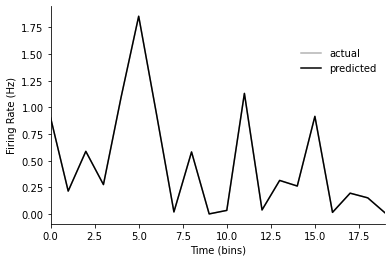

In [80]:
from nems.visualization.fitter import prediction_vs_target

ax = prediction_vs_target(data, target, fitted_model)